# Project : ResNet Ablation Study

# 1. CIFAT-10 데이터셋 준비하기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from keras import models, layers
# from keras import Input
# from keras.models import Model, load_model
# from keras.preprocessing.image import ImageDataGenerator
# from keras import optimizers, initializers, regularizers, metrics
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

import tensorflow_datasets as tfds
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
type(ds_train)

tensorflow.python.data.ops.dataset_ops._OptionsDataset

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 

print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 

print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


## 1-1. Input Normalization

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 2. ResNet 기본 블록 구성하기

In [8]:
# Convolution block

def conv_batch(layer, channel, kernel_size, padding='same',
              strides=1, activation='relu', name='0'):
    
    x = keras.layers.Conv2D(
        filters = channel,
        kernel_size = kernel_size,
        kernel_initializer = 'he_normal',
        kernel_regularizer = keras.regularizers.l2(1e-4),
        padding = padding,
        strides = strides,
        name = f'conv_{name}')(layer)
    
    x = keras.layers.BatchNormalization(
        name = f'batch_{name}')(x)
    
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
        
    return x

In [9]:
def build_residual_block(
    input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    
    x = input_layer
    
    # ResNet 50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_batch(x, channel*4, (1, 1), strides=2, 
                                      activation=None, name=f'_shortcut_{block_num}_{i}')
                
                x = conv_batch(x, channel, (1, 1), strides=2, 
                               name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3, 3), 
                               name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1),
                               activation=None, name=f'{block_num}_{i}3')
            else:
                    shortcut = x
                    x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                    x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                    x = conv_batch(x, channel*4, (1,1), 
                                   activation=None, name=f'{block_num}_{i}3')
                    
                    x = keras.layers.Add(
                        name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
                    x = keras.layers.Activation(
                        'relu', name=f'shortcut_act_{block_num}_{i}')(x)
        
    # ResNet 34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_batch(x, channel, (1, 1), strides=2,
                                     activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
                
            else:
                shortcut = x
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    

    return x 

In [12]:
def build_resnet(num_cnn_list, channel_list, is_50=True, cats_vs_dogs=False,
                input_shape=(32, 32, 3), num_classes=10, name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7, 7), strides=2, name='first')
    res = keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name='maxpool_first')(conv1)
    
    # Residual block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = build_residual_block(res, block_num, cnn, channel, is_50)
        gap = keras.layers.GlobalAveragePooling2D(name='GAP')(res)
        
        if cats_vs_dogs:
            output = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal', name='FC')(gap)
            
        else:
            output = keras.layers.Dense(num_classes, activation='softmax', kernel_initializer='he_normal', name='FC')(gap)
        
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model
                                                                                                                      

## 2-1. ResNet-34, ResNet-50 Complete Model

### 2-1-1. ResNet-34

In [13]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

### 2-1-2. ResNet-50

In [14]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3))
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

# 3. 일반 네트워크(plain network) 만들기

## 3-1. Plain block

In [15]:
def build_plain_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # plain_50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
    # plain_34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')

    return x

## 3-2. Build plain network

In [16]:
def build_plain(num_cnn_list, channel_list, is_50=True, cats_vs_dogs=False, input_shape=(32,32,3), num_classes=10, name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    plain = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # plain block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = build_plain_block(plain, block_num, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(plain)
    
    if cats_vs_dogs:
        output = keras.layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    
    return model

## 3-3. Plain-34

In [17]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

## 3-4. Plain-50

In [18]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

# 4. ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

## 4-1. Dataset(cats & dog)

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [20]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [21]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [22]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224,224)) # resize
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [23]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

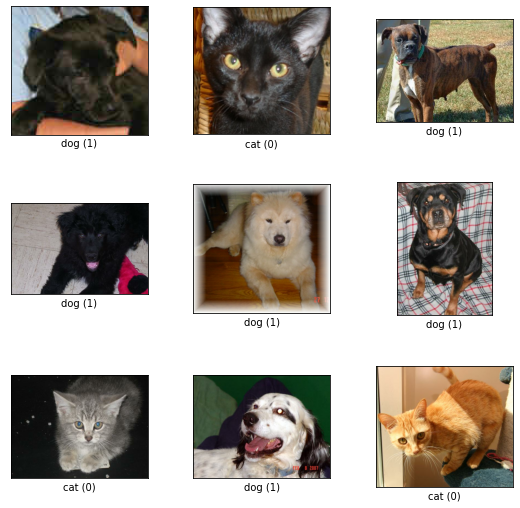

In [24]:
fig = tfds.show_examples(ds_train, ds_info)

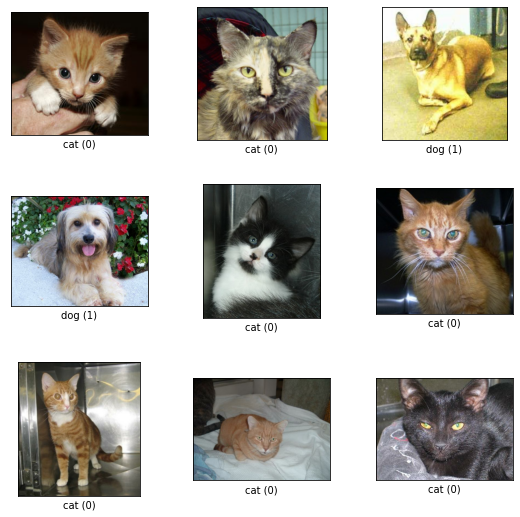

In [25]:
fig = tfds.show_examples(ds_test, ds_info)

## 4-2 Training data

In [26]:
BATCH_SIZE = 32 #256
iteration = 15000 #600000
EPOCH = iteration*BATCH_SIZE//int(ds_info.splits['train'].num_examples)

In [27]:
int(ds_info.splits['train'].num_examples)

23262

In [28]:
EPOCH

20

In [29]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [30]:
def scheduler(epoch, lr):
    if epoch == EPOCH//2:
        lr *=0.1
        print(lr)
    elif epoch == (EPOCH//4)*3:
        lr *=0.1
        print(lr)
    return lr

In [31]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, monitor='val_loss', patience=1, verbose=2, min_lr=1e-6)
# lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [32]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         cats_vs_dogs=True,
                         input_shape=(224,224,3),
                         name='ResNet_34')

In [33]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 345s 483ms/step - loss: 2.5008 - accuracy: 0.5431 - val_loss: 2.2032 - val_accuracy: 0.5123
Epoch 2/20
654/654 [==============================] - 295s 451ms/step - loss: 1.9395 - accuracy: 0.6242 - val_loss: 1.7943 - val_accuracy: 0.5775
Epoch 3/20
654/654 [==============================] - 295s 452ms/step - loss: 1.6111 - accuracy: 0.6697 - val_loss: 1.5164 - val_accuracy: 0.6432
Epoch 4/20
654/654 [==============================] - 296s 452ms/step - loss: 1.3429 - accuracy: 0.7098 - val_loss: 1.2904 - val_accuracy: 0.6883
Epoch 5/20
654/654 [==============================] - 296s 452ms/step - loss: 1.1116 - accuracy: 0.7615 - val_loss: 1.2273 - val_accuracy: 0.6688
Epoch 6/20
654/654 [==============================] - 296s 452ms/step - loss: 0.9110 - accuracy: 0.8089 - val_loss: 1.1473 - val_accuracy: 0.5696
Epoch 7/20
654/654 [==============================] - 296s 453ms/step - loss: 0.7466 - accuracy: 0.8510 - val_loss: 0.7867 -

In [34]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         cats_vs_dogs=True,
                         input_shape=(224,224,3))

In [35]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 273s 352ms/step - loss: 5.3462 - accuracy: 0.5205 - val_loss: 4.2773 - val_accuracy: 0.5473
Epoch 2/20
654/654 [==============================] - 212s 325ms/step - loss: 4.0539 - accuracy: 0.5661 - val_loss: 3.4103 - val_accuracy: 0.6340
Epoch 3/20
654/654 [==============================] - 203s 310ms/step - loss: 3.2311 - accuracy: 0.6472 - val_loss: 2.9786 - val_accuracy: 0.5629
Epoch 4/20
654/654 [==============================] - 202s 309ms/step - loss: 2.6082 - accuracy: 0.6861 - val_loss: 2.3838 - val_accuracy: 0.5430
Epoch 5/20
654/654 [==============================] - 202s 309ms/step - loss: 2.1318 - accuracy: 0.7081 - val_loss: 2.2151 - val_accuracy: 0.5469
Epoch 6/20
654/654 [==============================] - 202s 309ms/step - loss: 1.7451 - accuracy: 0.7397 - val_loss: 1.8315 - val_accuracy: 0.5849
Epoch 7/20
654/654 [==============================] - 202s 309ms/step - loss: 1.4513 - accuracy: 0.7672 - val_loss: 1.4716 -

In [36]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3),
                       name='Plain_34')

In [38]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 292s 430ms/step - loss: 2.2088 - accuracy: 0.5024 - val_loss: 1.9093 - val_accuracy: 0.5104
Epoch 2/20
654/654 [==============================] - 281s 430ms/step - loss: 1.8219 - accuracy: 0.5512 - val_loss: 1.6255 - val_accuracy: 0.5430
Epoch 3/20
654/654 [==============================] - 281s 430ms/step - loss: 1.5600 - accuracy: 0.5506 - val_loss: 1.3797 - val_accuracy: 0.6165
Epoch 4/20
654/654 [==============================] - 281s 430ms/step - loss: 1.3407 - accuracy: 0.6034 - val_loss: 1.3097 - val_accuracy: 0.5823
Epoch 5/20
654/654 [==============================] - 281s 430ms/step - loss: 1.1801 - accuracy: 0.6241 - val_loss: 1.0947 - val_accuracy: 0.6189
Epoch 6/20
654/654 [==============================] - 282s 431ms/step - loss: 1.0407 - accuracy: 0.6588 - val_loss: 1.0673 - val_accuracy: 0.5803
Epoch 7/20
654/654 [==============================] - 282s 431ms/step - loss: 0.9451 - accuracy: 0.6643 - val_loss: 0.9874 -

In [39]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3))

In [40]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 467s 663ms/step - loss: 5.1617 - accuracy: 0.5038 - val_loss: 4.2796 - val_accuracy: 0.5078
Epoch 2/20
654/654 [==============================] - 448s 684ms/step - loss: 4.0565 - accuracy: 0.5358 - val_loss: 3.4596 - val_accuracy: 0.4822
Epoch 3/20
654/654 [==============================] - 429s 657ms/step - loss: 3.2813 - accuracy: 0.5401 - val_loss: 2.8080 - val_accuracy: 0.5773
Epoch 4/20
654/654 [==============================] - 440s 673ms/step - loss: 2.6663 - accuracy: 0.5964 - val_loss: 2.3520 - val_accuracy: 0.5171
Epoch 5/20
654/654 [==============================] - 433s 663ms/step - loss: 2.2031 - accuracy: 0.6216 - val_loss: 1.9599 - val_accuracy: 0.5356
Epoch 6/20
654/654 [==============================] - 433s 662ms/step - loss: 1.8635 - accuracy: 0.5865 - val_loss: 1.6759 - val_accuracy: 0.5385
Epoch 7/20
654/654 [==============================] - 433s 663ms/step - loss: 1.6021 - accuracy: 0.5780 - val_loss: 1.4446 -

## 4-3. 비교

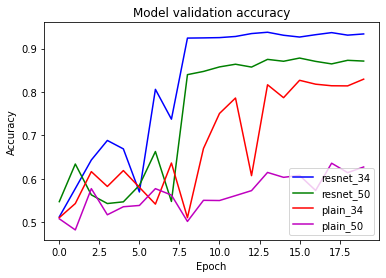

In [41]:
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'g')
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='lower right')
plt.show()

# 5. 회고

- 직접 만들고 해봤을 때 성능이 좋지 않아서 다양한 코드들을 참고해보면서 어떤식으로 모델을 구축했는지 확인해봤다.
- 논문을 보고 모델을 구축하는데 있어 조금이나마 익숙해진거 같다.